**List 7** - Algorithms and Data Structures 2021/22, WUST - F13

*Author:* Mateusz Machaj, 262288

*Date:* 24.01.2022

# Import

There are the imports I use. `graphviz` have to be installed both in Python (`pip install graphviz`) and on OS (`winget install graphviz` for Windows), with added executable file to the *PATH*.

In [229]:
from __future__ import annotations

import queue
import sys
import warnings
from typing import Any, List, Optional, Set, Tuple, Union, Dict

# grapviz have to be installed in Program Files and added to the PATH
import graphviz

The following lines are to change the warning message format and skip the traceback info.

In [230]:
def no_traceback_warning(
    message, category, filename=None, lineno=None, file=None, line=None
):
    return "{cat}: {mess}\n".format(cat=category.__name__, mess=message)


warnings.formatwarning = no_traceback_warning

Moreover, a hashable checker. It is not explcitely avaliable in pure Python.

In [3]:
def hashable(variable):
    try:
        hash(variable)
    except TypeError:
        return False
    return True

-----------------------

# Task 1

_**Graph class implementation**_

-----------------------

The basic graph with the methods from the lecture [[1]](#ref1) is consists of the nodes. These classes are partially copied from the referenced lecture. However, there are some changes and I have added node and edge deletion. There is also an option to create **directed** or **undirected** graph.

In the second one we cannot connect one node with itself (by edge), because that is the rule from definition. The first option allows it though.

In my implementation adding a node with the key that already exist does not affect the structure. Nothing changes. Similarly, adding the existing edge only updates its weight. 

## Node

I begin with creating the node class used later in the graph. It will contain also the features required for searching algorithms in the next tasks.

I do not use unncessary `get` and `set` methods for attributes, because the code is written with respect to Python conventions.

In [4]:
class Node:
    def __init__(self, key: Any):
        self.key = key
        self.neighbors = dict()
        self.neighbor_for = set()

        self.dist = sys.maxsize  # "infinity"
        self.color = "w"
        self.pred = None
        self.disc = 0
        self.fin = 0

    def reset(self):
        self.dist = sys.maxsize
        self.color = "w"
        self.pred = None
        self.disc = 0
        self.fin = 0

    def add_neighbor(self, neighbor: Node, weight: float = 0):
        self.neighbors[neighbor] = weight
        neighbor.neighbor_for.add(self)

    def rem_neighbor(self, neighbor: Node) -> Optional[Node]:
        popped = self.neighbors.pop(neighbor, None)
        if popped is None:
            return False
        else:
            neighbor.neighbor_for.remove(self)
            return True

    def get_weight(self, neighbor: Node) -> float:
        try:
            weight = self.neighbors[neighbor]
        except KeyError as key:
            raise Exception(
                'Node "{key}" is not a neighbor of this node.'.format(key=key)
            )
        else:
            return weight

    def __str__(self):
        return (
            str(self.key)
            + ";color "
            + self.color
            + ";discovery "
            + str(self.disc)
            + ";finish "
            + str(self.fin)
            + ";distance "
            + str(self.dist)
            + ";predecessor \n\t["
            + str(self.pred)
            + "]\n"
        )

## Graph

The following class is only the basic graph version supporting:

- **directed** and **undirected** graph versions;
- **node** and **edge** addition - as one element or by a list,
- **node** and **edge** deletion - as one element or by a list,
- getting **nodes** and **edges** listed,
- getting **node's** object by key,
- `in` operator for node keys,
- checking the size (number of nodes and number of edges)
- iteration.

Each edge is weighted (in case the weight is not given it defaults to 0). Nodes can have alphaumeric or string keys but do not contain additional value data. 

<u>IMPORTANT:</u> Getting node's object is an internal method becouse is should not be allowed for the class user to easily manipulate the graph components.

In [5]:
class GraphBasic:
    def __init__(self, directed: bool = True):
        self.nodes = dict()
        self.node_count = 0
        self.edge_count = 0
        self.directed = directed

    def __contains__(self, key: Any) -> bool:
        return key in self.nodes

    def _get_node_obj(self, key: float) -> Optional[Node]:
        try:
            des_node = self.nodes[key]
        except KeyError:
            return None
        else:
            return des_node

    def get_nodes(self) -> Set[Any]:
        return set(self.nodes.keys())

    def _get_nodes_obj(self) -> Set[Node]:
        return set(self.nodes.values())

    def get_edges(
        self,
    ) -> Union[Set[Tuple[Any, Any, float]], Set[Tuple[Set[Any, Any], float]]]:
        edge_set = set()

        def edge_tup_repr(from_key, to_info):
            if self.directed:
                return (from_key, to_info[0].key), to_info[1]
            else:
                return frozenset({from_key, to_info[0].key}), to_info[1]

        for key, node in self.nodes.items():
            edges_pr = map(
                lambda to_info: edge_tup_repr(key, to_info), node.neighbors.items()
            )
            new_edges = set(edges_pr)
            edge_set.update(new_edges)

        return edge_set

    def add_node(self, key: Any) -> Node:
        if not hashable(key):
            raise TypeError("Each key has to be hashable.")
        if key not in self:
            new_node = Node(key)
            self.nodes[key] = new_node
            self.node_count += 1
            return new_node
        else:
            warnings.warn(
                'Key "{key}" was already in the graph. Foregoing neighbors are keeped.'.format(
                    key=key
                ),
                category=DeprecationWarning,
            )
            return self.nodes[key]

    def add_edge(
        self,
        from_key: Any,
        to_key: Any,
        weight: float = 0,
    ):
        if not hashable(from_key) or not hashable(to_key):
            raise TypeError("Each key has to be hashable.")
        if not self.directed and from_key == to_key:
            raise ValueError(
                'Creating "{key}"-"{key}" edge failed. Undirected graph cannot contain self connecting nodes.'.format(
                    key=from_key
                )
            )

        for key in [from_key, to_key]:
            if key not in self:
                self.add_node(key)

        from_node = self.nodes[from_key]
        to_node = self.nodes[to_key]
        if not (to_node in from_node.neighbors):
            self.edge_count += 1
        from_node.add_neighbor(to_node, weight)

        if not self.directed:
            to_node.add_neighbor(from_node, weight)

    def del_node(self, key: Any):
        curr_node = self._get_node_obj(key)
        if curr_node is None:
            warnings.warn(
                'Key "{key}" is not in the graph. This node was not deleted.'.format(
                    key=key
                ),
                category=DeprecationWarning,
            )
        else:
            con_nodes = curr_node.neighbor_for.copy()
            for node in con_nodes:
                node.rem_neighbor(curr_node)
            self.nodes.pop(key)
            self.node_count -= 1

    def del_edge(
        self,
        from_key: Any,
        to_key: Any,
    ):
        nodes_exist = True
        edge_exist = True
        for key in [from_key, to_key]:
            if key not in self:
                nodes_exist = False
                warnings.warn(
                    'Key "{key}" is not in the graph.'.format(key=key),
                    category=DeprecationWarning,
                )
        if nodes_exist:
            from_node = self.nodes[from_key]
            to_node = self.nodes[to_key]
            success = from_node.rem_neighbor(to_node)
            self.edge_count -= 1
            if not self.directed:
                to_node.rem_neighbor(from_node)
            if success:
                edge_exist = False
        if not nodes_exist or not edge_exist:

            def relat_symb():
                return "->" if self.directed else "<->"

            warnings.warn(
                'Nonexistent "{fr}"{rel_s}"{to}" edge was not deleted.'.format(
                    fr=from_key, to=to_key, rel_s=relat_symb()
                ),
                category=DeprecationWarning,
            )

    def add_nodes(self, key_list: List[Any]):
        for key in key_list:
            self.add_node(key)

    def add_edges(
        self,
        edge_list: List[
            Tuple[
                Any,
                Any,
                float,
            ]
        ],
    ):
        for edge in edge_list:
            self.add_edge(*edge)

    def del_edges(
        self,
        edge_list: List[
            Tuple[
                Any,
                Any,
            ]
        ],
    ):
        for edge in edge_list:
            self.del_edge(*edge)

    def del_nodes(self, key_list: List[Any]):
        for key in key_list:
            self.del_node(key)

    def size(self):
        return {"nodes": self.node_count, "edges": self.edge_count}

    def __iter__(self):
        return iter(self.nodes.values())

## Presentation

All the features are shown in the next task, because of visualization available.

-----------------------

# Task 2

_**Graph visualisation in "dot"**_

-----------------------

The only thing there is the visualization method added. I use `graphviz` library and `dot` language as it was given.

## Enhanced graph class 

In [6]:
class GraphVis(GraphBasic):
    def visualize(self) -> Union[graphviz.graphs.Digraph, graphviz.graphs.Graph]:
        if self.directed:
            dot = graphviz.Digraph()
        else:
            dot = graphviz.Graph()
        dot.attr("node", style="filled", fillcolor="lightblue2")
        for key in self.get_nodes():
            dot.node(str(key))
        for node_keys, weight in self.get_edges():
            from_node, to_node = list(node_keys)
            edge_data = list(map(str, [from_node, to_node, weight]))
            dot.edge(*edge_data)

        return dot

-----------------------

# Task 3

_**Graph searching methods - BFS and DFS**_

-----------------------

In [233]:
class GraphSearch(GraphVis):
    def __init__(self, directed: bool = True):
        super().__init__(directed)
        self._time = 0
        self._has_cycles = False

    def _time_it(self):
        self._time += 1
        return self._time

    def _reset_hdata(self):
        self._time = 0
        self._has_cycles = False
        for node in self._get_nodes_obj():
            node.reset()

    def _mark_bfs(self, start_node: Node):
        start_node.dist = 0
        bfs_queue = queue.SimpleQueue()
        bfs_queue.put_nowait(start_node)

        while not bfs_queue.empty():
            curr_node = bfs_queue.get_nowait()
            for neigh_node in curr_node.neighbors:
                if neigh_node.color == "w":
                    neigh_node.color = "g"
                    neigh_node.disc = self._time_it()
                    neigh_node.dist = curr_node.dist + 1
                    neigh_node.pred = curr_node
                    bfs_queue.put_nowait(neigh_node)
            curr_node.color = "b"
            curr_node.fin = self._time_it()
            
    def _mark_dfs(self, start_node: Node):
        start_node.color = "g"
        start_node.disc = self._time_it()
        for neigh_node in start_node.neighbors:

            # Additional feature - chcecking the cycles OTF
            if neigh_node.color == "g":
                self._has_cycles = True

            if neigh_node.color == "w":
                neigh_node.dist = start_node.dist + 1
                neigh_node.pred = start_node
                self._mark_dfs(neigh_node)
        start_node.color = "b"
        start_node.fin = self._time_it()
        
    def _traversal(self, start_key: Any, trav_method: function) -> Dict[str, List[Any]]:
        start_node = self._get_node_obj(start_key)
        if not start_node:
            raise Exception("Start point is not in the graph.")
        self._reset_hdata()
        trav_method(start_node)
        node_list = self._get_nodes_obj()
        disc_times = {node.disc: node.key for node in node_list if node.disc != 0}
        fin_times = {node.fin: node.key for node in node_list if node.fin != 0}

        traversal = {
            "discovered": list(map(lambda elem: elem[1], sorted(disc_times.items()))),
            "finished": list(map(lambda elem: elem[1], sorted(fin_times.items()))),
        }
        self._reset_hdata()
        return traversal
    
    def trav_bfs(self, start_key: Any) -> Dict[str, List[Any]]:
        return self._traversal(start_key, self._mark_bfs)
    
    def trav_dfs(self, start_key: Any) -> Dict[str, List[Any]]:
        return self._traversal(start_key, self._mark_dfs)

    def find_path(self, from_key: Any, to_key: Any) -> List[Any]:
        from_node = self._get_node_obj(from_key)
        to_node = self._get_node_obj(to_key)
        if not (from_node and to_node):
            raise Exception("Path points are not in the graph.")
        self._reset_hdata()
        self._mark_bfs(from_node)
        path_list = []
        if to_node.pred:
            curr_node = to_node
            while curr_node:
                path_list.append(curr_node.key)
                curr_node = curr_node.pred

            self._reset_hdata()
            return path_list[::-1]
        else:
            self._reset_hdata()
            raise Exception("Given nodes are not connected.")

-----------------------

# Task 4

_**DFS features modification - topological sorting**_

-----------------------

In [234]:
# note about the separate method

In [235]:
class GraphTopo(GraphSearch):
    def topo_sort(self) -> List[Any]:
        if not self.directed:
            raise Exception("Undirected graph cannot be sorted topologically.")
        self._reset_hdata()
        visit_times = dict()
        for node in self.nodes.values():
            if node.color == "w":
                self._mark_dfs(node)
        if self._has_cycles:
            raise Exception("Graph with cycles cannot be sorted topologically.")
        for key, node in self.nodes.items():
            visit_times[node.fin] = key
        sorted_visits = sorted(visit_times.items(), reverse=True)
        sorted_keys = [tup[1] for tup in sorted_visits]
        self._reset_hdata()
        return sorted_keys

    def vis_line_order(self, subgraph_keys: List[Any]) -> graphviz.graphs.Digraph:
        if not self.directed:
            raise Exception("Undirected graph cannot be visualized this way.")
        for key in subgraph_keys:
            if key not in self.get_nodes():
                raise Exception("Invalid nodes on the list.")

        dot = graphviz.Digraph()
        dot.attr("node", style="filled", fillcolor="lightblue2")
        for key in subgraph_keys:
            dot.node(str(key))
        for node_keys, weight in self.get_edges():
            from_node, to_node = list(node_keys)
            if from_node in subgraph_keys and to_node in subgraph_keys:
                edge_data = list(map(str, [from_node, to_node]))
                dot.edge(*edge_data, constraint="false")

        return dot

In [236]:
a = GraphTopo()
a.add_node("ą")
a.add_edges([("a", "d", 3), ("c", "b", 2), ("b", "a", 1)])
a.add_edges([("c", "e"), ("e", (2.4, 5), 4), ("e", "g", 5), ("e", "d", 5)])

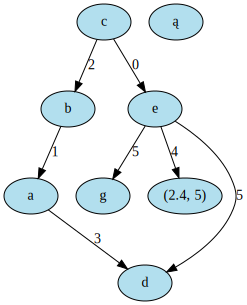

In [237]:
a.visualize()

In [239]:
a.trav_dfs("c")

{'discovered': ['c', 'b', 'a', 'd', 'e', (2.4, 5), 'g'],
 'finished': ['d', 'a', 'b', (2.4, 5), 'g', 'e', 'c']}

-----------------------

# Task 5

_**Optimal paths between the nodes**_

-----------------------

In [176]:
class GraphPaths(GraphTopo):
    # def topo_sort(self):
    #     if not self.directed:
    #         raise Exception("Undirected graph cannot be sorted topologically.")
    #     self._reset_hdata()
    #     visit_times = dict()
    #     for node in self.nodes.values():
    #         if node.color == "w":
    #             self._mark_dfs(node)
    #     if self._has_cycles:
    #         raise Exception("Graph with cycles cannot be sorted topologically.")
    #     for node in self.nodes.values():
    #         visit_times[node.fin] = node
    #     sorted_visits = sorted(visit_times.items(), reverse=True)
    #     sorted_nodes = [tup[1] for tup in sorted_visits]
    #     return sorted_nodes

    def opt_paths(self, start_key: Any):
        pass

In [14]:
class Graph(GraphPaths):
    pass

-----------------------

# Task 6

_**"Missionaries and cannibals" problem**_

-----------------------

-----------------------

# Task 7

_**"Water in buckets" problem**_

-----------------------

In [98]:
class TwoBucketSet:
    def __init__(self, left: int, right: int, left_max: int, right_max: int):
        if not all(
            map(lambda v: isinstance(v, int), [left, right, left_max, right_max])
        ):
            raise TypeError("Volumes have to be integers.")
        if 0 <= left <= left_max and 0 <= right <= right_max:
            self._left = left
            self._right = right
            self._left_max = left_max
            self._right_max = right_max
        else:
            raise Exception("Invalid volumes.")

    def fill_left(self) -> Optional[TwoBucketSet]:
        if self._left != self._left_max:
            return TwoBucketSet(
                self._left_max,
                self._right,
                self._left_max,
                self._right_max,
            )
        else:
            return None

    def fill_right(self) -> Optional[TwoBucketSet]:
        if self._right != self._right_max:
            return TwoBucketSet(
                self._left,
                self._right_max,
                self._left_max,
                self._right_max,
            )
        else:
            return None

    def spill_left(self) -> Optional[TwoBucketSet]:
        if self._left != 0:
            return TwoBucketSet(0, self._right, self._left_max, self._right_max)
        else:
            return None

    def spill_right(self) -> Optional[TwoBucketSet]:
        if self._right != 0:
            return TwoBucketSet(self._left, 0, self._left_max, self._right_max)
        else:
            return None

    def pour_to_left(self) -> Optional[TwoBucketSet]:
        left_diff = self._left_max - self._left
        if left_diff and self._right:
            poured = min(left_diff, self._right)
            new_left = self._left + poured
            new_right = self._right - poured
            return TwoBucketSet(new_left, new_right, self._left_max, self._right_max)
        else:
            return None

    def pour_to_right(self) -> Optional[TwoBucketSet]:
        right_diff = self._right_max - self._right
        if right_diff and self._left:
            poured = min(right_diff, self._left)
            new_left = self._left - poured
            new_right = self._right + poured
            return TwoBucketSet(new_left, new_right, self._left_max, self._right_max)
        else:
            return None

    def do_actions(self):
        moves = [
            self.fill_left(),
            self.fill_right(),
            self.spill_left(),
            self.spill_right(),
            self.pour_to_left(),
            self.pour_to_right(),
        ]
        legal_moves = list(filter(None, moves))
        return legal_moves

    def total_vol(self) -> int:
        return self._left + self._right

    def __str__(self) -> str:
        return ", ".join(map(str, [self._left, self._right]))

    def __repr__(self) -> str:
        return "TwoBucketSet(({l}, {r}), of({lm}, {rm}))".format(
            l=str(self._left),
            r=str(self._right),
            lm=str(self._left_max),
            rm=str(self._right_max),
        )

    def __eq__(self, other):
        if type(other) is type(self):
            condits = [
                self._left == other._left,
                self._right == other._right,
                self._left_max == other._left_max,
                self._right_max == other._right_max,
            ]
            return all(condits)
        else:
            return False

    def __hash__(self):
        return hash((self._left, self._right, self._left_max, self._right_max))

In [99]:
def bucket_build_graph(max_vol_a: int, max_vol_b: int) -> Graph:
    bucket_graph = Graph()
    init_condit = TwoBucketSet(0, 0, max_vol_a, max_vol_b)
    bucket_graph.add_node(init_condit)

    def branch(curr_state: TwoBucketSet):
        new_states = curr_state.do_actions()
        for state in new_states:
            is_new = not (state in bucket_graph.get_nodes())
            bucket_graph.add_edge(curr_state, state, 1)
            if is_new:
                branch(state)

    branch(init_condit)
    return bucket_graph

In [104]:
def find_bucket_steps(
    max_vol_a: int, max_vol_b: int, des_vol: int
) -> List[TwoBucketSet]:
    bucket_graph = bucket_build_graph(max_vol_a, max_vol_b)
    paths = []
    std_init = TwoBucketSet(0, 0, max_vol_a, max_vol_b)
    for node in bucket_graph.get_nodes():
        if node.total_vol() == des_vol:
            paths.append(bucket_graph.find_path(std_init, node))
    opt_path = sorted(paths, key=len)[0]
    return opt_path

In [126]:
MAX_VOL_A = 3
MAX_VOL_B = 4
DES_VOL = 2

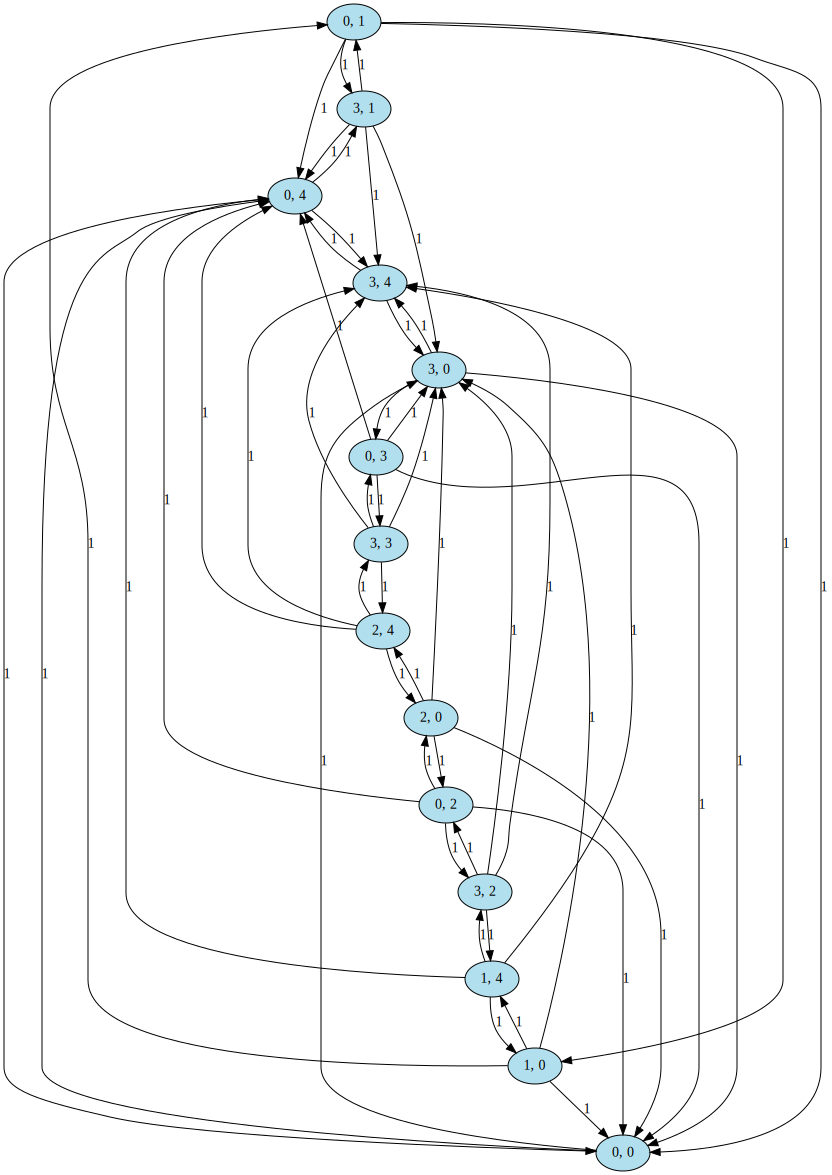

In [131]:
bucket_graph = bucket_build_graph(MAX_VOL_A, MAX_VOL_B)
bucket_graph.visualize()

In [130]:
find_bucket_steps(MAX_VOL_A, MAX_VOL_B, DES_VOL)

[TwoBucketSet((0, 0), of(3, 4)),
 TwoBucketSet((3, 0), of(3, 4)),
 TwoBucketSet((0, 3), of(3, 4)),
 TwoBucketSet((3, 3), of(3, 4)),
 TwoBucketSet((2, 4), of(3, 4)),
 TwoBucketSet((2, 0), of(3, 4))]

-----------------------

# References

-----------------------

<a id="ref1">[1]</a> J. Szwabiński, *Wykład 10 - Grafy i podstawowe algorytmy grafowe*,  *Algorytmy i struktury danych*, p. 2-16. [accessed: 24.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/10.pdf.

-----------------------